In [1]:
#%matplotlib widget

In [2]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from ephysvibe.task import task_constants,def_task
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import select_trials,align_trials
from ephysvibe.trials.spikes import firing_rate
#firing_rate.moving_average
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
seed=2024

In [3]:
def plot3d_pcs(mean_co_pcs,n_pcs,area):
    fix_idx = np.arange(0,100,2)
    fix2_idx = np.arange(100,200,2)
    samp1_idx = np.arange(200,400,2)
    samp2_idx = np.arange(400,650,2)
    delay_idx = np.arange(650,1000,2)

    for i in np.arange(0,1,2):
        fig,ax = plt.subplots(1,2,figsize=(16,6),sharey=True,sharex=True, subplot_kw={'projection': '3d'})#
        
        ax[0].plot(mean_co_pcs[i][fix_idx],mean_co_pcs[i+1][fix_idx],mean_co_pcs[i+2][fix_idx],label='fixation')
        ax[0].plot(mean_co_pcs[i][fix2_idx],mean_co_pcs[i+1][fix2_idx],mean_co_pcs[i+2][fix2_idx],label='fixation2')
        ax[0].plot(mean_co_pcs[i][samp1_idx],mean_co_pcs[i+1][samp1_idx],mean_co_pcs[i+2][samp1_idx],label='sample first part')
        ax[0].plot(mean_co_pcs[i][samp2_idx],mean_co_pcs[i+1][samp2_idx],mean_co_pcs[i+2][samp2_idx],label='sample 2nd part')
        ax[0].plot(mean_co_pcs[i][delay_idx],mean_co_pcs[i+1][delay_idx],mean_co_pcs[i+2][delay_idx],label='delay')
        
        ax[1].plot(n_pcs[i][fix_idx],n_pcs[i+1][fix_idx],n_pcs[i+2][fix_idx],label='fixation')
        ax[1].plot(n_pcs[i][fix2_idx],n_pcs[i+1][fix2_idx],n_pcs[i+2][fix2_idx],label='fixation2')
        ax[1].plot(n_pcs[i][samp1_idx],n_pcs[i+1][samp1_idx],n_pcs[i+2][samp1_idx],label='sample first ms')
        ax[1].plot(n_pcs[i][samp2_idx],n_pcs[i+1][samp2_idx],n_pcs[i+2][samp2_idx],label='sample 2nd ms')
        ax[1].plot(n_pcs[i][delay_idx],n_pcs[i+1][delay_idx],n_pcs[i+2][delay_idx],label='delay')



### With new structure

In [4]:
import platform

In [5]:
if platform.system() == 'Linux':
    basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/'
elif platform.system() == 'Windows':
    basepath = 'C:/Users/camil/Documents/int/'#'//envau_cifs.intlocal.univ-amu.fr/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/' #

In [6]:
def z_score(x):
    mu = np.mean(x,axis=0)
    sigma = np.std(x,axis=0)
    sigma0=sigma
    sigma0[sigma == 0] = 1 
    zs_x = (x-mu) / sigma0
    return zs_x

In [142]:
def get_fr_samples(neu_data,time_before,start,end,rng):
    # Select trials aligned to sample onset
    # parameters
    select_block=1
    code=1
    idx_start = time_before + start 
    idx_end = time_before+end
    sp_sample_on,mask = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= 0,
    )
    if np.sum(mask)<20:
        return None
    len_tr = idx_end-(idx_start)
    n_trials = 10
    sample_id = neu_data.sample_id[mask]
    fr_samples = []
    for s_id in [11,15,55,51]:
        sample_fr = sp_sample_on[np.where(sample_id==s_id,True,False)]
        # Check number of spikes
        n_sp = np.sum(sample_fr[:,idx_start:idx_end],axis=1)
        n_sp_per_sec = n_sp >= len_tr*4/1000
        sample_fr=sample_fr[n_sp_per_sec]
        if sample_fr.shape[0]< n_trials:
            return None
        
        rng.shuffle(sample_fr,axis=0)

        avg_sample = firing_rate.moving_average(sample_fr, win=100, step = 1)[:,idx_start:idx_end]
        fr_zs=z_score(avg_sample)[:n_trials]
        #np.mean(avg_sample,axis=0)#
        fr_samples.append(fr_zs)
    #fr_samples =np.concatenate(fr_samples)
 
    #fr_samples=np.array(np.concatenate(fr_samples,axis=0))
   
    return np.array(fr_samples)


In [143]:
neu_path = basepath+"/session_struct/lip/neurons/*neu.h5"
path_list = glob.glob(neu_path)

In [144]:
def get_neuron_sample_fr(path,time_before,start,end,rng):
    
    neu_data = NeuronData.from_python_hdf5(path)
    fr_samples = get_fr_samples(neu_data,time_before=time_before,start=start,end=end,rng=rng)
    if fr_samples is None:
        return {'fr':None}
    #fr_samples = np.concatenate(fr_samples)
    return {'fr':fr_samples}

In [145]:
# Load data
time_before=500
start=-200
end=850
idx_start = time_before + start 
idx_end = time_before+end
rng = np.random.default_rng(seed=seed)
data = Parallel(n_jobs = -1)(delayed(get_neuron_sample_fr)(path,time_before,start,end,rng) for path in tqdm(path_list))

100%|██████████| 530/530 [02:26<00:00,  3.62it/s]


In [ ]:
200+450+400

1050

In [148]:
fr_concat.shape

(40, 1050)

In [146]:
neurons_fr = []
for asc in data:
    fr = asc["fr"]
    if fr is not None:
        print(fr.shape)
        fr_concat = np.concatenate(fr)#[:,idx_start:idx_end])
        #print(fr_concat.shape)
        neurons_fr.append(fr_concat)
        #neurons_fr.append(fr)


(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10, 1050)
(4, 10

In [149]:
np.concatenate(neurons_fr).shape

(11640, 1050)

In [150]:
neurons_fr = np.concatenate(neurons_fr)#.reshape(-1,1050)
neurons_fr.shape

(11640, 1050)

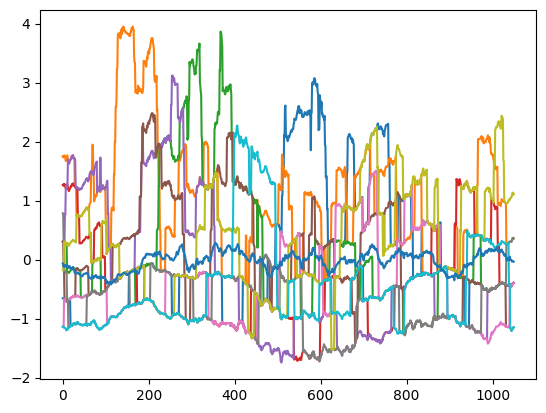

In [151]:
_=plt.plot(neurons_fr[0:10,:1050].T)
_=plt.plot(neurons_fr[0:20,:1050].mean(axis=0))

In [152]:
neurons_fr.shape

(11640, 1050)

In [153]:
n_comp = 100#zs_fr.shape[0]
model = PCA(n_components=n_comp).fit(neurons_fr.T)
C = model.components_
pc_s = C @ neurons_fr
model

PCA(n_components=100)

In [154]:
pc_s.shape

(100, 1050)

In [155]:
pc_s.shape

(100, 1050)

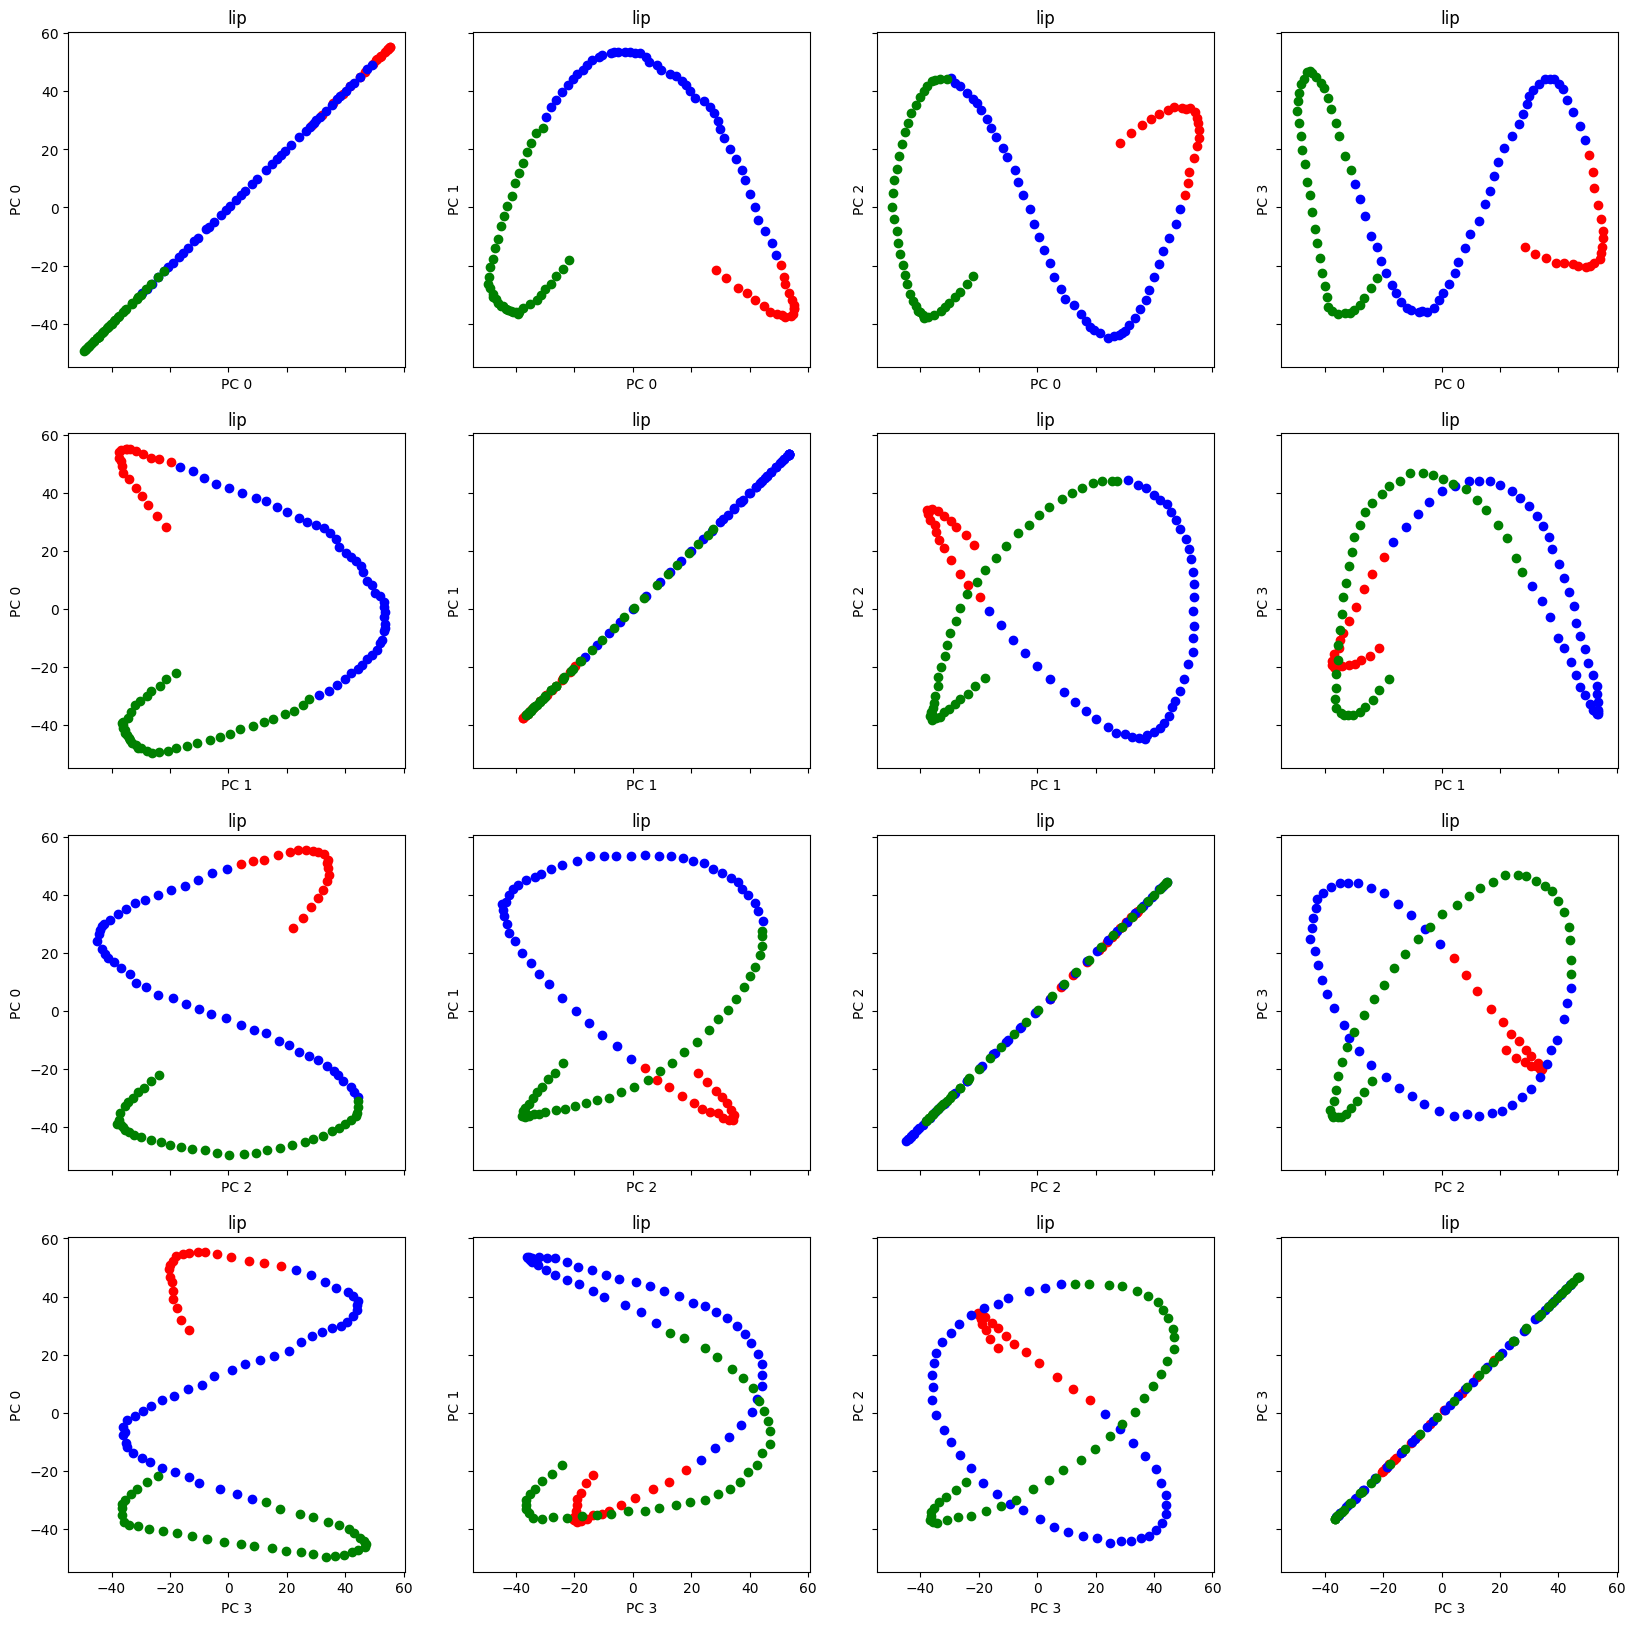

In [156]:
# reshape_pc_s = pc_s.reshape(n_comp,-1,1200)#int(zs_fr.shape[1]/4)
# #co_pcs = reshape_pc_s[:,0,:]
# reshape_pc_s= np.mean(reshape_pc_s,axis=1)
i=0
fig,ax = plt.subplots(4,4,figsize=(20,20),sharex=True,sharey=True)
idx_f = np.arange(0,200,10)
idx_s = np.arange(200,200+450,10)
idx_d = np.arange(200+450,pc_s.shape[1],10)
for i in np.arange(0,4):
    for j in np.arange(0,4):
        ax[i,j].scatter(pc_s[i][idx_f],pc_s[j][idx_f],color='r',label='fixation')
        ax[i,j].scatter(pc_s[i][idx_s],pc_s[j][idx_s],color='b',label='sample first part')
        ax[i,j].scatter(pc_s[i][idx_d],pc_s[j][idx_d],color='g',label='delay')
        ax[i,j].set(xlabel="PC "+str(i), ylabel="PC "+str(j),title='lip')

In [22]:
# reshape_pc_s = pc_s.reshape(n_comp,-1,1050)


# mean_co_pcs = np.mean(co_pcs,axis=1)

# fig,ax = plt.subplots(4,1,figsize=(10,10),sharex=True,sharey=True)
    
# for i_pc in np.arange(0,4):
#     for i_cond in np.arange(4):
#         n_pcs = reshape_pc_s[i_pc,i_cond,:]

#         ax[i_pc].plot(n_pcs,label=i_cond)

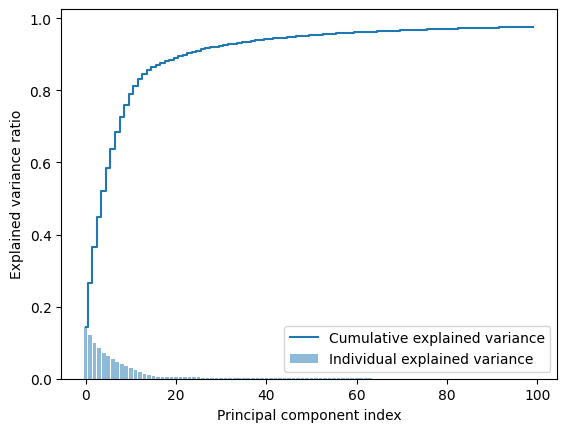

In [157]:
fig,ax = plt.subplots()
exp_var_pca = model.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [158]:
np.where(cum_sum_eigenvalues>0.8)[0][0]

11

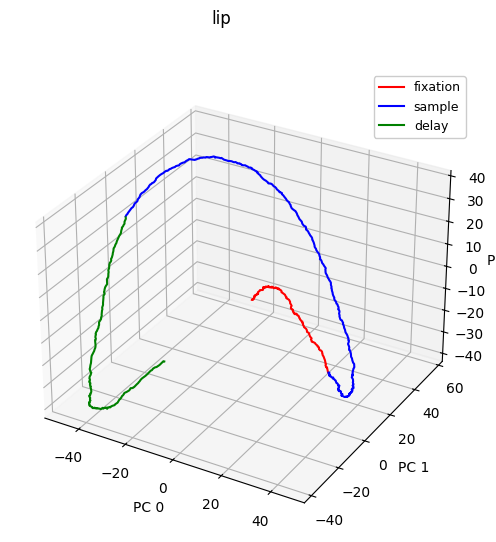

In [159]:
fig,ax = plt.subplots(figsize=(16,6),sharey=True,sharex=True, subplot_kw={'projection': '3d'})#
i=0
area='lip'
ax.plot(mean_co_pcs[i][:200],mean_co_pcs[i+1][:200],mean_co_pcs[i+2][:200],'r',label='fixation')
ax.plot(mean_co_pcs[i][200:200+450],mean_co_pcs[i+1][200:200+450],mean_co_pcs[i+2][200:200+450],'b',label='sample')
ax.plot(mean_co_pcs[i][200+450:],mean_co_pcs[i+1][200+450:],mean_co_pcs[i+2][200+450:],'g',label='delay')
fig.suptitle(area)
ax.set(xlabel="PC "+str(i), ylabel="PC "+str(i+1), zlabel="PC "+str(i+2))
ax.legend(fontsize=9,columnspacing=0.5,facecolor='white', framealpha=1,loc='upper right')